In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
from sparse_rf.algs import *
from sparse_rf.modules import make_X, make_A
from sparse_rf.util import *
import sparse_rf.util.fns as fns 
import sparse_rf.util.polynomials as poly
from functools import partial
import random
import gc
from sklearn.preprocessing import MinMaxScaler

import sys

In [15]:
def make_W(d, q, n=1, dist=normal):
    num_supports = comb(d, q)
    W = np.zeros((n*num_supports, d))
    inds = combinations(range(d), d-q)
    ds = set(range(d))
    inds_track = []
    for i in range(num_supports):
        ind = next(inds)
        inds_track.append(ds.difference(set(ind)))
        for j in range(n):
            w = dist(d)
            w[list(ind)] = 0
            W[i*n+j, :] = w
    return W, inds_track

In [112]:
data = np.loadtxt("airfoil_self_noise.dat")

ratio_train = 0.8
ratio_val = 0
ratio_test = 0.2

X = data[:, :-1]
y = data[:, -1]

m = len(y)

In [113]:
d = X.shape[-1]
q = 1
N = 250
n = N//comb(d, q)
w_scale = 1/np.sqrt(q)
active = fourier

train_val_inds = np.arange(int(m*ratio_test), m)
train_inds = np.sort(np.random.choice(train_val_inds, int(m*ratio_train), replace=False))
val_inds = np.setdiff1d(train_val_inds, train_inds)

X_train = X[train_inds, :]
X_val = X[val_inds, :]
y_train = y[train_inds]
y_val = y[val_inds]

X_test = X[:int(m*ratio_test), :]
y_test = y[:int(m*ratio_test)]

np.linalg.norm(y_train)

4353.207241754406

In [114]:
norm = MinMaxScaler().fit(X_train)
X_train = norm.transform(X_train)
X_val = norm.transform(X_val)
X_test = norm.transform(X_test)


In [115]:
W, inds = make_W(d, q, n=n, dist=partial(normal, stdev=w_scale))
A_train = make_A(X_train, W, active=active)
A_val = make_A(X_val, W, active=active)
A_test = make_A(X_test, W, active=active)
inds

[{4}, {3}, {2}, {1}, {0}]

In [116]:
c_l2 = min_l2(A_train, y_train)
np.linalg.norm(A_val@c_l2-y_val) / np.linalg.norm(y_val)

0.034011475777511964

In [119]:
A_val.shape

(1, 500)

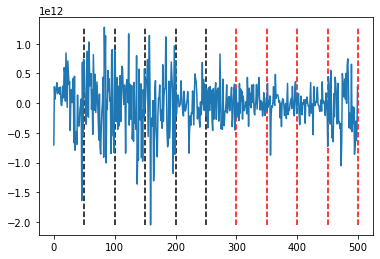

In [117]:
plt.plot(c_l2)
for i in range(len(inds)):
    plt.vlines((len(c_l2)//(2*len(inds)))*(i+1), min(c_l2), max(c_l2), color="black", linestyles="--")
for i in range(len(inds)):
    plt.vlines((len(c_l2)//(2*len(inds)))*(i+len(inds)+1), min(c_l2), max(c_l2), color="red", linestyles="--")

In [30]:
c_l1 = min_l1(A_train, y_train, eta=0)
np.linalg.norm(A_val@c_l1-y_val) / np.linalg.norm(y_val)

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001


0.029140214431061177

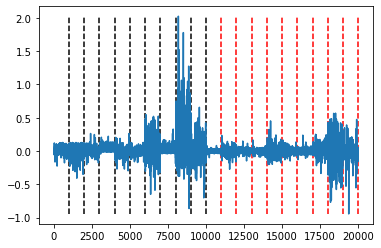

In [31]:
plt.plot(c_l1)
for i in range(len(inds)):
    plt.vlines((len(c_l1)//(2*len(inds)))*(i+1), min(c_l1), max(c_l1), color="black", linestyles="--")
for i in range(len(inds)):
    plt.vlines((len(c_l1)//(2*len(inds)))*(i+len(inds)+1), min(c_l1), max(c_l1), color="red", linestyles="--")

In [32]:
len(np.nonzero(c_l1)[0])

20000

## TESTING

In [69]:
np.linalg.norm(A_test@c_l1-y_test) / np.linalg.norm(y_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20000 is different from 500)

In [120]:
np.linalg.norm(A_test@c_l2-y_test) / np.linalg.norm(y_test)

216517165.85708198

In [88]:
X_val

array([[0.03030303, 0.18018018, 1.        , 1.        , 0.06214979],
       [0.11616162, 0.18018018, 1.        , 1.        , 0.06214979],
       [0.03030303, 0.18018018, 1.        , 0.6010101 , 0.06697943],
       ...,
       [0.11616162, 0.7027027 , 0.375     , 0.19949495, 0.90411066],
       [0.1489899 , 0.7027027 , 0.375     , 0.19949495, 0.90411066],
       [0.24242424, 0.7027027 , 0.375     , 0.19949495, 0.90411066]])

In [92]:
blah = np.arange(m)

In [94]:
blah[:int(m*ratio_test)]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [95]:
blah[train_inds]

array([ 300,  302,  303,  304,  305,  307,  308,  309,  310,  311,  312,
        313,  314,  315,  316,  317,  318,  320,  323,  324,  325,  326,
        328,  329,  330,  331,  332,  333,  334,  335,  336,  337,  339,
        340,  341,  342,  343,  347,  349,  350,  353,  356,  357,  363,
        365,  366,  367,  368,  371,  372,  373,  374,  375,  376,  377,
        380,  381,  382,  383,  384,  386,  387,  388,  390,  392,  393,
        394,  396,  397,  398,  399,  400,  401,  402,  403,  404,  406,
        407,  408,  409,  410,  411,  412,  413,  414,  415,  416,  417,
        418,  420,  421,  422,  423,  424,  428,  429,  431,  432,  433,
        434,  435,  437,  439,  440,  441,  443,  445,  447,  449,  451,
        452,  453,  454,  455,  456,  457,  458,  459,  460,  461,  462,
        463,  466,  467,  470,  471,  474,  475,  476,  477,  478,  479,
        480,  482,  484,  485,  486,  488,  489,  490,  491,  494,  495,
        496,  497,  498,  499,  501,  502,  504,  5

In [96]:
blah[val_inds]

array([ 301,  306,  319,  321,  322,  327,  338,  344,  345,  346,  348,
        351,  352,  354,  355,  358,  359,  360,  361,  362,  364,  369,
        370,  378,  379,  385,  389,  391,  395,  405,  419,  425,  426,
        427,  430,  436,  438,  442,  444,  446,  448,  450,  464,  465,
        468,  469,  472,  473,  481,  483,  487,  492,  493,  500,  503,
        506,  509,  513,  516,  517,  521,  532,  549,  557,  560,  563,
        570,  573,  581,  586,  587,  588,  590,  592,  594,  597,  600,
        602,  604,  608,  614,  615,  618,  620,  622,  624,  629,  637,
        640,  650,  651,  654,  657,  672,  673,  678,  684,  686,  692,
        693,  703,  707,  713,  718,  721,  729,  731,  733,  737,  738,
        739,  744,  745,  746,  748,  749,  754,  757,  770,  779,  780,
        782,  784,  786,  787,  793,  794,  800,  807,  808,  812,  813,
        822,  835,  836,  840,  841,  844,  853,  860,  861,  862,  867,
        869,  870,  875,  880,  883,  892,  897,  9